## load in Rascal matrices

In [674]:
import pickle
rascal_run = pickle.load(open('/mnt/store1/oliverphilcox/LowR__mean.pkl',"rb"),encoding='latin1')

c2r=rascal_run['c2'][100:,100:]
c3r=rascal_run['c3'][100:,100:]
c4r=rascal_run['c4'][100:,100:]
rr=rascal_run['Ra'][100:]

r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv').mean(axis=1)
mu_bins = np.arange(0.05,1.05,0.1)

all_r = np.asarray([r_bins[i//10] for i in range(len(c2r))])
r_matrix = np.matmul(all_r.reshape(-1,1),all_r.reshape(1,-1))

Calibrate N-gal via Corrfunc RR counts:

In [675]:
rr_cf = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/binned_pair_counts_n35_m10_j169_11.dat')/100.
rescaling=np.sqrt(np.median(rr/rr_cf))

## Load RascalC matrices

In [676]:
%pylab inline
file_root = '/mnt/store1/oliverphilcox/DR12_QPM/output_rascal_nocorr/'
weight_dir = '/mnt/store1/oliverphilcox/DR12_QPM/'
m=10;n=35;n_jack=169
n_bins=n*m
n_samples = 20

Populating the interactive namespace from numpy and matplotlib


In [677]:
# script to post-process covariance matrices for each QPM mock + produces an npz output file 
import sys,os


weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_11.dat'%(n,m,n_jack)
RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_11.dat'%(n,m,n_jack)

print("Loading weights file from %s"%weight_file)
weights = np.loadtxt(weight_file)[:,1:]

print("Loading weights file from %s"%RR_file)
RR=np.loadtxt(RR_file)

Loading weights file from /mnt/store1/oliverphilcox/DR12_QPM/jackknife_weights_n35_m10_j169_11.dat
Loading weights file from /mnt/store1/oliverphilcox/DR12_QPM/binned_pair_counts_n35_m10_j169_11.dat


In [678]:
def load_matrices(index):
    """Load intermediate or full covariance matrices"""
    cov_root = file_root+'CovMatricesAll/'
    c2 = np.diag(np.loadtxt(cov_root+'c2_n%d_m%d_11_%s.txt'%(n,m,index)))/rescaling**2.
    c3 = np.loadtxt(cov_root+'c3_n%d_m%d_1,11_%s.txt'%(n,m,index))/rescaling
    c4 = np.loadtxt(cov_root+'c4_n%d_m%d_11,11_%s.txt'%(n,m,index))
    # Now symmetrize and return matrices
    return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

RR = np.loadtxt(file_root+'CovMatricesAll/RR_n%d_m%d_11_full.txt'%(n,m))*rescaling**2.

# Load in full jackknife theoretical matrices
print("Loading best estimate of covariance matrix")
c2,c3,c4=load_matrices('full')

# Load in partial jackknife theoretical matrices
c2s,c3s,c4s=[],[],[]
for i in range(n_samples):
    #print("Loading jackknife subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i)
    c2s.append(cc2)
    c3s.append(cc3)
    c4s.append(cc4)

# Compute inverted matrix
def Psi(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    c_tot = c2*alpha**2.+c3*alpha+c4
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi



Loading best estimate of covariance matrix


## Compare matrices

In [679]:
c_rascal = lambda alpha: c2r*alpha**2.+c3r*alpha+c4r
c_rascalC = lambda alpha: c2*alpha**2.+c3*alpha+c4

In [680]:
def D_KL(prec,mat):
    """Return KL divergence"""
    logdetPrec = np.sum(np.log(np.linalg.eigvalsh(prec)))
    logdetMat = np.sum(np.log(np.linalg.eigvalsh(mat)))
    if np.isnan(logdetPrec):
        return np.inf
    if np.isnan(logdetMat):
        return np.inf
    return 0.5*(np.trace(np.matmul(prec,mat))-len(prec)-logdetPrec-logdetMat)

In [681]:
alphas=np.linspace(0.8,1.3,10)
KL_divs = np.asarray([D_KL(Psi(al),c_rascal(al)) for al in alphas])

In [682]:
n_eff_KL = n_bins*(n_bins+1.)/(4.*KL_divs)

Compute the n_eff for the two models, via variance in off-diagonal elements.

In [683]:
def other_n_eff(prec):
    i=np.arange(len(prec))
    filt=np.where(r_bins[i//10]>142)
    filt2 = np.where(r_bins[i//10]<82)
    psis=[]
    for f in filt[0]:
        for f2 in filt2[0]:
            psis.append(prec[f,f2]/np.sqrt(prec[f,f]*prec[f2,f2]))
    var=np.var(psis)
    n_bins = len(prec)
    return n_bins+1./var

n_eff_rascal = lambda alpha: other_n_eff(np.linalg.inv(c_rascal(alpha)))
n_eff_rascalC = lambda alpha: other_n_eff(np.linalg.inv(c_rascalC(alpha)))

Text(0.5,0,'$\\alpha$')

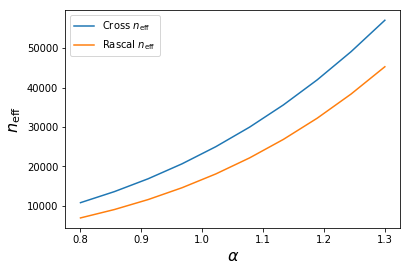

In [684]:
dat_rascal = [n_eff_rascal(al) for al in alphas]
dat_rascalC = [n_eff_rascalC(al) for al in alphas]
plt.plot(alphas,n_eff_KL,label=r'Cross $n_\mathrm{eff}$')
plt.plot(alphas,dat_rascal,label='Rascal $n_\mathrm{eff}$')
#plt.plot(alphas,dat_rascalC,label='RascalC $n_\mathrm{eff}$')
plt.legend();#plt.yscale('log')
plt.ylabel('$n_\mathrm{eff}$',fontsize=16);plt.xlabel(r'$\alpha$',fontsize=16)

Get jackknife error bars on these?

# Check jackknife variance prescription

In [686]:
cross_n_eff=np.zeros(len(alphas))
cross_n_eff_err = np.zeros(len(alphas))
for a,alpha in enumerate(alphas):
    print("Computing for alpha %d of %d"%(a+1,len(alphas)))
    c_indivs = [c2s[i]*alpha**2.+c3s[i]*alpha+c4s[i] for i in range(20)]
    n_effs=[]
    for s in range(20):
        these_c = np.mean(c_indivs[:s]+c_indivs[s+1:],axis=0)
        this_KL=D_KL(np.linalg.inv(these_c),c_rascal(alpha))
        n_effs.append(n_bins*(n_bins+1.)/(4.*this_KL))
    full_KL = D_KL(np.linalg.inv(np.mean(c_indivs,axis=0)),c_rascal(alpha))
    full_n_eff=n_bins*(n_bins+1.)/(4.*full_KL)
    n_eff_var = 19./20.*np.sum((np.asarray(n_effs)-np.mean(n_effs,axis=0))**2.)
    cross_n_eff[a]=full_n_eff
    cross_n_eff_err[a]=np.sqrt(n_eff_var)

Computing for alpha 1 of 10
Computing for alpha 2 of 10
Computing for alpha 3 of 10
Computing for alpha 4 of 10
Computing for alpha 5 of 10
Computing for alpha 6 of 10
Computing for alpha 7 of 10
Computing for alpha 8 of 10
Computing for alpha 9 of 10
Computing for alpha 10 of 10


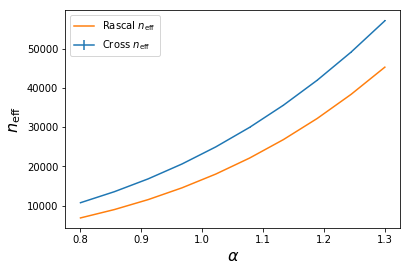

In [687]:
dat_rascal = [n_eff_rascal(al) for al in alphas]
#dat_rascalC = [n_eff_rascalC(al) for al in alphas]
plt.errorbar(alphas,cross_n_eff,yerr=cross_n_eff_err,label=r'Cross $n_\mathrm{eff}$')
plt.plot(alphas,dat_rascal,label='Rascal $n_\mathrm{eff}$')
#plt.plot(alphas,dat_rascalC,label='RascalC $n_\mathrm{eff}$')
plt.legend();#plt.yscale('log')
plt.ylabel('$n_\mathrm{eff}$',fontsize=16);plt.xlabel(r'$\alpha$',fontsize=16);

Check out the discriminant matrix $\sqrt\Psi^TC\sqrt\Psi - \mathbb{I}$

In [688]:
chol = np.linalg.cholesky(Psi(1.))
disc = np.matmul(chol.T,np.matmul(c_rascal(1.),chol))-np.eye(len(chol))

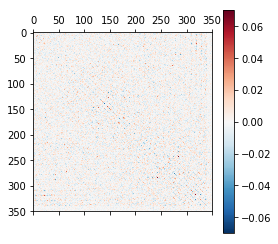

In [689]:
plt.matshow(disc,cmap=cm.RdBu_r,vmax=0.07,vmin=-0.07);plt.colorbar();

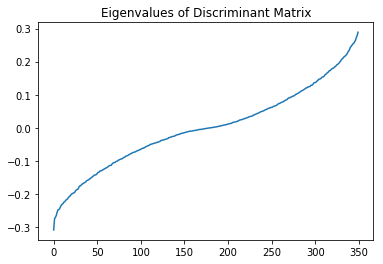

In [690]:
plt.plot(np.linalg.eigvalsh(disc))
plt.title('Eigenvalues of Discriminant Matrix');

## Look at the Stacked Residuals

In [691]:
def residuals(matrix,prec=False):
    r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv').mean(axis=1)
    mu_bins_tmp = np.linspace(0.,1.,m+1)
    mu_bins = np.mean([mu_bins_tmp[1:],mu_bins_tmp[:-1]],axis=0)

    n=len(r_bins)
    r_bins_all = np.concatenate([[r_bins[i] for _ in range(m)] for i in range(len(r_bins))])
    mu_bins_all = np.hstack([mu_bins for _ in range(len(r_bins))])
    r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))
    
    if prec:
        resid=matrix/r_matrix
    else:
        resid=matrix*r_matrix
    
    r_diff = []
    for rr in r_bins:
        for rr2 in r_bins:
            r_diff.append(rr-rr2)
    r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
    mu_diff = []
    for mu in mu_bins:
        for mu2 in mu_bins:
            mu_diff.append(mu-mu2)
    mu_diff = np.unique(np.asarray(mu_diff).round(8)) # remove rounding errors

    mu_edge = np.linspace(-1,1,len(mu_diff)+1)
    delta_r = r_diff[1]-r_diff[0]
    r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)
    mu_edges = np.vstack([mu_edge for _ in range(len(r_edge))])
    r_edges = np.vstack([r_edge for _ in range(len(mu_edge))])

    stacked_resid = np.zeros([len(mu_diff),len(r_diff)])
    denom = np.zeros([len(mu_diff),len(r_diff)])
    for i in range(len(resid)):
        for j in range(resid.shape[1]):
            r_index = np.where((r_bins_all[i]-r_bins_all[j]).round(3)==r_diff.round(3))
            mu_index = np.where((mu_bins_all[i]-mu_bins_all[j]).round(4)==mu_diff.round(4))
            stacked_resid[mu_index,r_index]=resid[i,j]
            denom[mu_index,r_index]+=1
    stacked_resid=np.divide(stacked_resid,denom)
    return r_edges,mu_edges,stacked_resid

def resid_plot(resid_data,vmax=0.5,title='',FS=16):
    r_edges,mu_edges,stacked_resid=resid_data
    plt.pcolor(mu_edges.T,r_edges,stacked_resid,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.ylim([-30,30]);
    plt.xlim([-0.5,0.5])
    plt.colorbar();FS=16
    plt.ylabel(r'$\Delta r$',fontsize=FS);plt.xlabel(r'$\Delta\mu$',fontsize=FS);
    if len(title)>0:
        plt.title(title,fontsize=FS)

In [692]:
resid_data=residuals(np.linalg.inv(c_rascal(1.))-np.linalg.inv(c_rascalC(1.)),prec=True)

In [701]:
resid_data2=residuals(np.linalg.inv(c_rascal(1.)),prec=True)

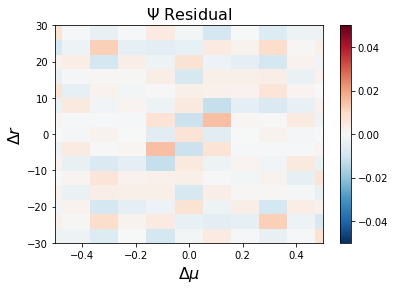

In [694]:
resid_plot(resid_data,vmax=0.05,title=r'$\Psi$ Residual')

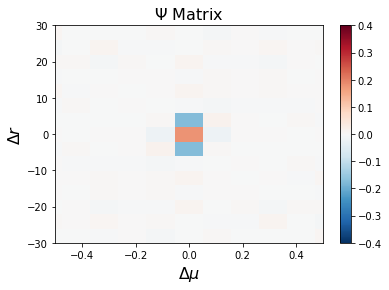

In [708]:
resid_plot(resid_data2,vmax=0.4,title=r'$\Psi$ Matrix')

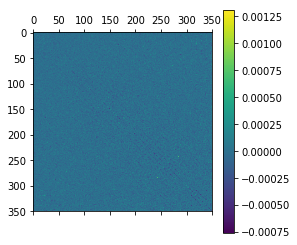

In [699]:
plt.matshow((c_rascal(1.)-c_rascalC(1.))*r_matrix);plt.colorbar()

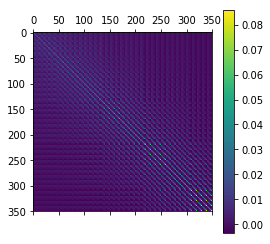

In [700]:
plt.matshow(c_rascal(1.)*r_matrix);plt.colorbar()

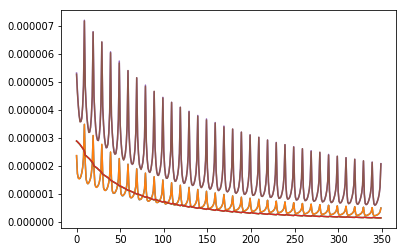

In [709]:
plt.plot(np.diag(c3))
plt.plot(np.diag(c3r))
plt.plot(np.diag(c2))
plt.plot(np.diag(c2r))
plt.plot(np.diag(c4))
plt.plot(np.diag(c4r))

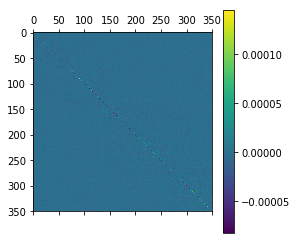

In [710]:
plt.matshow((c3-c3r)*r_matrix);plt.colorbar();

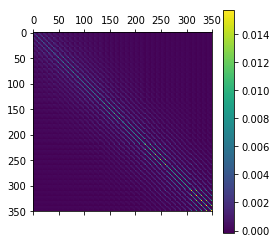

In [711]:
plt.matshow(c3r*r_matrix);plt.colorbar();

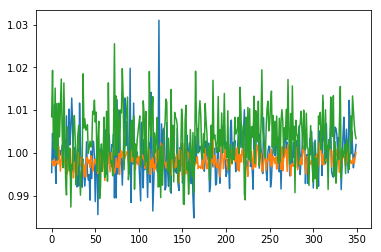

In [712]:
plt.plot(np.diag(c3)/np.diag(c3r))
plt.plot(np.diag(c2)/np.diag(c2r))
plt.plot(np.diag(c4)/np.diag(c4r))

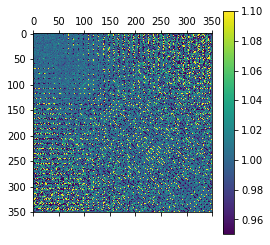

In [713]:
plt.matshow(np.divide(c4,c4r),vmax=1.1,vmin=0.95);plt.colorbar()

In [714]:
DKL=D_KL(c_rascal(1.),Psi(1.))
n_eff_D_KL=(n_bins*(n_bins+1.))/(4.*DKL)

In [715]:
D_KL(c_rascal(1.5),Psi(1.5))

0.32776409461075673

In [717]:
n_eff_D_KL

23148.429485051

Check the $\bar{n}(z)$ file of Rascal

In [716]:
nbar_file = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/nbar_DR12v5_CMASS_North_om0p31_Pfkp10000.dat')

In [491]:
zcen = nbar_file[:,0]
nbar=nbar_file[:,3]
wfkp=nbar_file[:,4]
vol=nbar_file[:,5]
weighted_ngal=nbar_file[:,6]

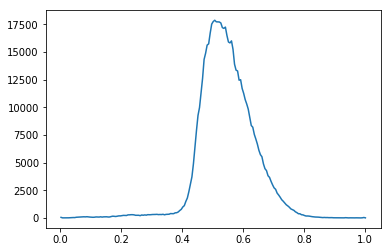

In [492]:
plt.plot(zcen,weighted_ngal)

In [92]:
np.sum(weighted_ngal)

662408.3781847

In [93]:
np.sum(vol*nbar)

662408.3748389779

Rescale to Omega_m = 0.29

In [99]:
rascal_run.keys()

dict_keys(['r_center', 'mu_center', 'rmins', 'mumins', 'survey_opts', 'NSamp', 'corr_opts', 'Ra', 'RASCAL_version', 'cx', 'descriptive_keys', 'c3', 'c2', 'repeats', 'c4'])

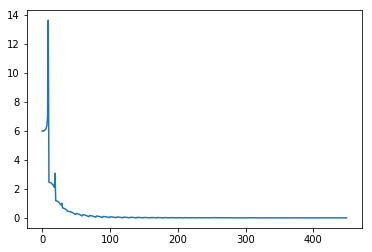

In [556]:
plt.plot(rascal_run['cx'])

In [557]:
rascal_run['repeats']

4

In [102]:
opts=rascal_run['survey_opts']

In [274]:
ramin  = float(opts['ramin'])
ramax  = float(opts['ramax'])
decmin = float(opts['decmin']) +90.
decmax = float(opts['decmax']) +90.
zmin   = float(opts['zmin'])
zmax   = float(opts['zmax'])

nbar_file = '/mnt/store1/oliverphilcox/DR12_QPM/nbar_DR12v5_CMASS_North_om0p31_Pfkp10000.dat'#opts['nbar_file']	#Currently it's assumed that this n(z) is defined from 0.43-0.7
#mask_file = opts['mask_file']

try:
    eff_area = opts['eff_area']
except KeyError:
    eff_area = 6.851419E+03

try:
    P_fkp = float(opts['p_fkp'])
except KeyError:
    P_fkp = 0	#When no P_fkp is specified, use wfkp from the nbar file

In [275]:
try:
    n_corr = float(opts['n_correction'])
except KeyError:
    n_corr = 0

In [323]:
# Loading the nbar file
zcen,zlo,zhi,nbar,wfkp,shell_vol,ngal = loadtxt(nbar_file,unpack=True,)

Omega_m = 0.29#float(opts['omega_m'])
h = float(opts['h'])

c = 299792.458

from scipy.integrate import quad
from scipy.interpolate import interp1d

#Distance function
def Einv(z):
    return 1./sqrt( Omega_m*(1+z)**3 + (1-Omega_m) )

nz = 10000
ztable = linspace(min(zlo),max(zhi),nz)
dtable = zeros(nz)
for i in range(nz):
    dtable[i] = (c/100) * quad(Einv,0,ztable[i])[0]

d = interp1d(ztable,dtable)

# Computing our own nbar
rlo = d(zlo)
rhi = d(zhi)

my_shell_vol = (1./3) * (rhi**3 - rlo**3) * eff_area * (4*pi/41253) #Last bit is the deg^2 -> steradians conversion
my_nbar = ngal/shell_vol
nbar_all = interp1d(d(zcen),my_nbar,bounds_error=False,fill_value=0)

f = where( (zcen>zmin) & (zcen<zmax) )[0]
my_rvals = zeros(len(f)+2)
my_rvals[0] = d(zmin)
my_rvals[-1] = d(zmax)
my_rvals[1:-1] = d(zcen[f])
old_nbar_r = interp1d(my_rvals,nbar_all(my_rvals),bounds_error=False,fill_value=0)

if (P_fkp != 0):
    def weight_r(r):
        return 1/(1+P_fkp * old_nbar_r(r))
else:
    wbar_all = interp1d(d(zcen),wfkp,bounds_error=False,fill_value=0)
    weight_r = interp1d(my_rvals,wbar_all(my_rvals),bounds_error=False,fill_value=0)

#I think we use the original nbar to compute the FKP weights, and only apply the correction later
if (n_corr != 0):
    nbar_all = interp1d(d(zcen),n_corr * my_nbar,bounds_error=False,fill_value=0)
    nbar_r = interp1d(my_rvals,nbar_all(my_rvals),bounds_error=False,fill_value=0)

(0, 10)

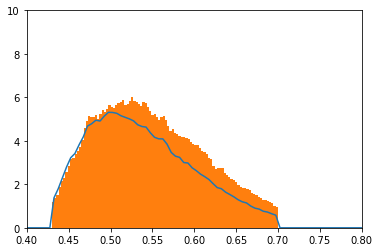

In [324]:
#plt.plot(zcen,nbar_r(d(zcen))*14000)
plt.plot(zcen,nbar_r(d(zcen))*np.sum(shell_vol)/np.sum(ngal))
plt.hist(dat[:,2],density=True,bins=100);
plt.xlim([0.4,0.8])
plt.ylim([0,10])
#plt.plot(zcen,weight_r(d(zcen)))
#plt.yscale('log')

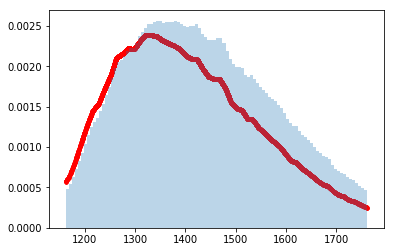

In [544]:
plt.hist(dat_r,bins=100,density=True,alpha=0.3);
plt.scatter(dat_r[:10000],nbar_r(dat_r[:10000])*5.8,marker='.',c='r')


Compute n(r) from data

In [549]:
r_bins = np.arange(400,2250,25)
r_min = r_bins[:-1]
r_max = r_bins[1:]
r_cen = np.mean([r_min,r_max],axis=0)
binned_n = np.zeros(len(r_bins)-1)
for di,d in enumerate(np.random.choice(dat_r,size=len(dat_r),replace=False)):
    if di>500000:
        break
    which_bin=np.where((d<r_max)&(d>r_min))
    binned_n[which_bin]+=0.1 # since 10x randoms
shell_vol = np.pi*4./3.*(r_max**3.-r_min**3.)*eff_area/41253

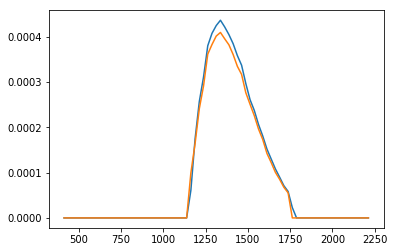

In [550]:
plt.plot(r_cen,binned_n/shell_vol*len(dat_r)/di)
plt.plot(r_cen,nbar_r(r_cen))

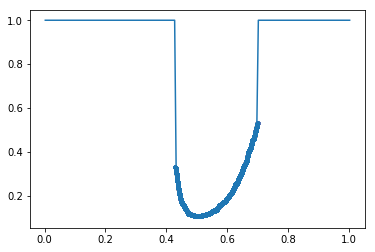

In [495]:
#plt.plot(zcen,nbar_r(d(zcen))*14000)
plt.plot(zcen,weight_r(d(zcen)))
plt.scatter(dat[:,2],dat[:,3],marker='.',alpha=0.01)
#plt.hist(dat[:,3],density=True,bins=100);
#plt.xlim([0.4,0.8])
#plt.ylim([0,3])
#plt.plot(zcen,weight_r(d(zcen)))
#plt.yscale('log')

In [256]:
## Load mock file:
dat=np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/unprocessed/mock_galaxy_DR12_CMASS_N_QPM_0001.rdzw')

KeyboardInterrupt: 

In [541]:
dat_xyz=np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/qpm_randoms_10x.xyzwj')

In [542]:
dat_r = np.sqrt(dat_xyz[:,0]**2.+dat_xyz[:,1]**2.+dat_xyz[:,2]**2.)

(array([ 38303.,  77493.,  94538., 100043.,  92236.,  76329.,  63638.,
         46051.,  32079.,  21341.]),
 array([0.430001 , 0.4570004, 0.4839998, 0.5109992, 0.5379986, 0.564998 ,
        0.5919974, 0.6189968, 0.6459962, 0.6729956, 0.699995 ]),
 <a list of 10 Patch objects>)

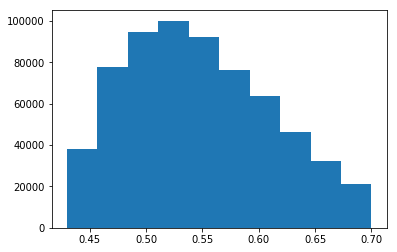

In [543]:
plt.hist(dat[:,2])

In [15]:
prec = lambda alpha: np.linalg.inv(c2r*alpha**2.+c3r*alpha+c4r)
cov = lambda alpha: c2r*alpha**2.+c3r*alpha+c4r
my_cov = lambda alpha: c2f*alpha**2.+c3f*alpha+c4f

In [21]:
def prec_plot(matrix,vmax=250):
    plt.matshow(matrix/r_matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);
def cov_plot(matrix,vmax=0.001):
    plt.matshow(matrix*r_matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);

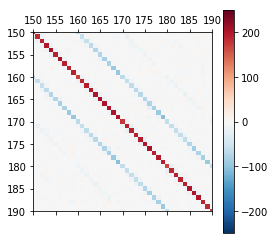

In [22]:
prec_plot(prec(0.8))

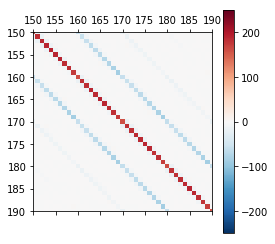

In [24]:
prec_plot(Psi(0.8))

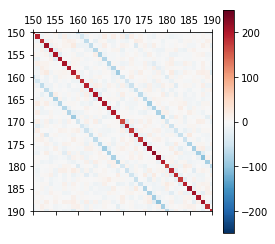

In [96]:
prec_plot(qpm_prec)

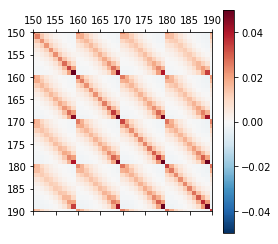

In [101]:
cov_plot(cov(1.),vmax=0.05)

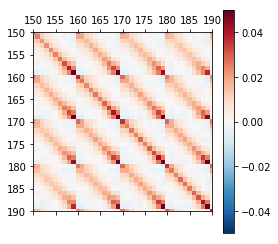

In [118]:
cov_plot(qpm_cov,vmax=0.05)

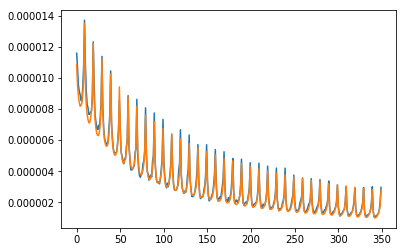

In [126]:
plt.plot(np.diag(qpm_cov))
plt.plot(np.diag(cov(1.04)))
#plt.plot(np.diag(my_cov(1.04)))

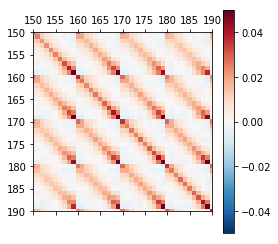

In [127]:
cov_plot(qpm_cov,vmax=0.05)

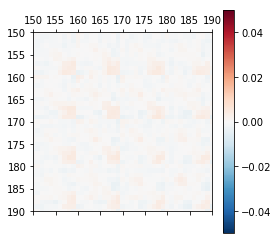

In [128]:
cov_plot(qpm_cov-my_cov(alpha_best_full),vmax=0.05)

Check precision matrices from subruns - is this a convergence issue?

In [177]:
cov_subrun = lambda alpha: c2fs[0]*alpha**2.+c3fs[0]*alpha+c4fs[0]
mean_cov = lambda alpha: np.mean(np.asarray(c2fs)*alpha**2.+np.asarray(c3fs)*alpha+np.asarray(c4fs),axis=0)
mean_prec = lambda alpha: np.linalg.inv(mean_cov(alpha))
prec_subrun = lambda alpha: np.linalg.inv(cov_subrun(alpha))

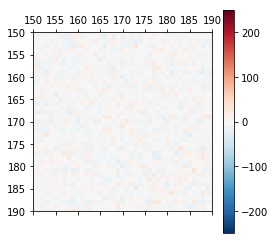

In [212]:
prec_plot(prec(0.8)-qpm_prec)

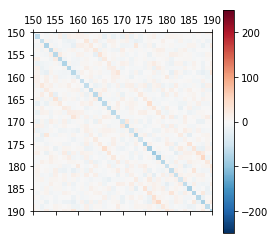

In [213]:
prec_plot(prec(1.)-qpm_prec)

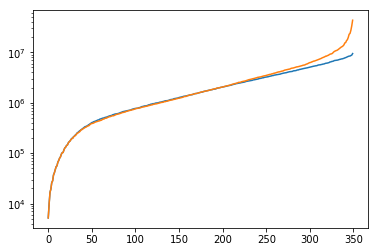

In [186]:
plt.plot(np.linalg.eigvalsh(mean_prec(0.8)))
plt.plot(np.linalg.eigvalsh(prec_subrun(0.8)))
plt.yscale('log')

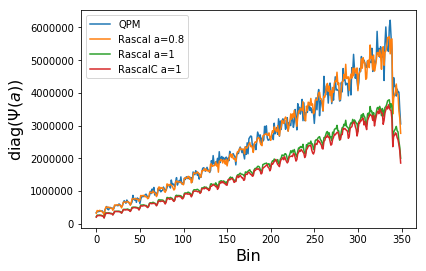

In [91]:
plt.plot(np.diag(qpm_prec),label='QPM')
plt.plot(np.diag(prec(0.8)),label='Rascal a=0.8')
plt.plot(np.diag(prec(1.)),label='Rascal a=1')
plt.plot(np.diag(Psi_full(1.)),label='RascalC a=1');
plt.legend()
plt.ylabel('$\mathrm{diag}(\Psi(a))$',fontsize=16)
plt.xlabel('Bin',fontsize=16);

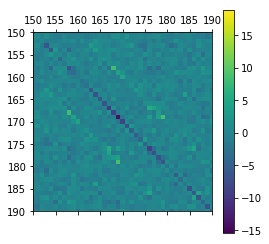

In [67]:
plt.matshow((Psi_full(1.)-prec(1.))/r_matrix);plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);